# 개요

본 노트북의 목적은 학습이 끝난 실험의 성능이 실제로 어떠한가를 다각적으로 검증하고, clustering을 classification으로 변환하였을 때 어떠한 결과가 나오는가를 확인하기 위함.

In [1]:
import json
import os
import torch
import numpy as np
from sklearn.cluster import (
    DBSCAN, 
    AffinityPropagation, 
    HDBSCAN
)
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import random

# 0704 sigma 실험

loss sigma를 1.0으로 두었을 때 FM 점수가 0.4대로 매우 높게 나오는 모델이 발견됨. 이를 살펴보고자 함.

In [2]:
os.chdir("/workspace/")

from dataset import *
from model import speaker_clustering

In [3]:
train_log_path = "/workspace/models_storage/cluster/l2_epsilon/log/train_at_2024-07-04_23_35.json"
train_log = []

with open(train_log_path, mode="r") as fp:
    train_log = json.loads(fp.read())

train_log

{'dataset_path': 'data/pdnc/novels',
 'save_dir': 'models_storage/cluster/l2_epsilon',
 'model_state_file': 'models_storage/cluster/l2_epsilon/model_2024-07-04_23_35.pth',
 'feature_dimension': 2048,
 'decoder_hidden': 1024,
 'feature_freedom': 1,
 'seed': 201456,
 'learning_rate': 2e-06,
 'adam_epsilon': 1e-08,
 'warmup_steps': 0,
 'weight_decay': 0.0,
 'saved_anchor_num': 2,
 'detach_mems_step': 5,
 'loss_sig': 1.0,
 'loss_epsilon': 10,
 'early_stopping_criteria': 5,
 'max_epochs': 15,
 'book_train_iter': 2,
 'reload_from_files': False,
 'expand_filepaths_to_save_dir': True,
 'log_json_file': 'models_storage/cluster/l2_epsilon/log/train_at_2024-07-04_23_35.json',
 'catch_keyboard_interrupt': True,
 'test': False,
 'log_dir': 'models_storage/cluster/l2_epsilon/log/',
 'cuda': True,
 'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_val': 0.4043824772004873,
 'epoch_index': 15,
 'train_loss': [0.14698808098290767,
  0.505345346411964,
  0.27858838364638144,
  0.0962

In [4]:
from transformers import (
    BertConfig, 
    BertTokenizer
)

# 모델 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
data_set = PDNCDataset(train_log["dataset_path"], tokenizer)


bert_config = BertConfig.from_pretrained("bert-base-uncased")
bert_config.decoder_intermediate_size = train_log["decoder_hidden"]
bert_config.feature_dimension = train_log["feature_dimension"]
bert_config.feature_freedom = train_log["feature_freedom"]
    
model = speaker_clustering.SpeakerClusterModel(bert_config)

model.load_state_dict(torch.load(os.path.join("/workspace/", train_log["model_state_file"])))

Some weights of InfiniBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.8.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.5.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.11.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.0.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.3.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.1.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.7.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.9.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.4.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.6.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.10.attention.self.fastweight_mem.head_gates', 'bert.encoder.layer.2.attention.self.fastweight_mem.head_gates']
You should probably TRAIN this model on a down-stream task to be able to use it for predic

<All keys matched successfully>

In [5]:
import torch.nn as nn

def get_model_prediction(batch_dict, tokenizer, model, device):
    seq_length = np.sum(batch_dict["x_length"])
    if seq_length > tokenizer.model_max_length:
        # 문단 길이가 context window를 초과할 때
        # 문단에서 발화자가 달라지지 않고 전체가 다 한 사람이 말한 것이거나 설명문이거나
        # 여러 번 출력을 받아 pooling하는 방식으로 해결
        process_num = (
            seq_length // tokenizer.model_max_length) + 1
        avg_pool = nn.AvgPool2d(
            kernel_size=(process_num, 1), stride=1)
        pred_features = []
        error_accum = 0
                        
        for i in range(process_num):
            x_i = batch_dict['x'][0][i * tokenizer.model_max_length - error_accum: min(
                seq_length, (i + 1) * tokenizer.model_max_length) - error_accum].reshape((1, -1))
            if x_i[0][0] != tokenizer.cls_token_id:
                x_i = batch_dict['x'][0][i * tokenizer.model_max_length - error_accum: min(
                    seq_length, (i + 1) * tokenizer.model_max_length - 1) - error_accum].reshape((1, -1))
                x_i = torch.cat(
                    (torch.tensor([[tokenizer.cls_token_id]]).to(device), x_i), dim=1)
                error_accum += 1

            pred = model(input_ids=x_i, cls_idx=[0])
            pred_features.append(pred[0][0])

        pred_features = torch.cat(pred_features, dim=0).reshape(
            (1, process_num, pred_features[0].shape[0]))
        y_pred = avg_pool(pred_features)

        y_pred = (y_pred.squeeze(0), None)
    else:
        y_pred = model(input_ids=batch_dict['x'], cls_idx=batch_dict["cls_index"])

    return y_pred

In [7]:
import tqdm.notebook as tqdm

val_bar = tqdm.tqdm(desc="",
                    total=10,
                    position=2, 
                    leave=True)

book_idx = 3

data_set.set_book(book_idx)

batch_generator = generate_pdnc_batches(data_set,
                                        max_seq_length=tokenizer.model_max_length,
                                        device="cpu")

model.eval()

val_bar.n = 0
val_bar.total = data_set.get_num_batches(1)
val_bar.desc = 'book{0} inference'.format(book_idx)

cls_features = []
speakers = []

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = get_model_prediction(batch_dict, tokenizer, model, "cpu")
    
    cls_features.extend([feature.detach().cpu().numpy() for feature in y_pred[0]])
    speakers.extend(batch_dict["speaker"])
    
    val_bar.update(len(batch_dict["speaker"]))
    model.detach_memories_()
    

  0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


## 

In [8]:
from metric import *

res = calc_v_measure_with_hdb(np.array(cls_features), speakers)

print(res)

(0.028851913534258204, 0.13231858914640712, 0.047373985059676244, None)


In [9]:
res = calc_adjusted_rand_with_hdb(np.array(cls_features), speakers)

print(res)

(0.36698396254923576, None)


In [40]:
hdb = HDBSCAN(store_centers="centroid").fit(np.array(cls_features))

In [122]:
hdb_leaf = HDBSCAN(store_centers="centroid", cluster_selection_method="leaf").fit(np.array(cls_features))

In [138]:
labels = hdb_leaf.labels_

In [134]:
labels = hdb.dbscan_clustering(cut_distance=0.3)

In [139]:
print(len(labels[labels != -1]))
print(len(labels))
print(len(set(labels[labels != -1])))

235
3191
26


In [140]:
labels[labels != -1]

array([ 3, 15, 20, 20, 20, 20, 16, 16, 16, 16, 16,  3, 14, 14, 14, 12, 12,
       12, 12, 12, 12, 17, 17, 17, 17, 17, 17, 17, 17, 17,  3,  2, 19, 19,
       19, 19, 19, 19, 19, 19, 19,  3,  2, 14,  2, 14, 14, 21, 21, 21, 21,
        4,  4,  4,  3,  6,  6,  0,  3, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24,  3,  2, 19, 19, 19, 19, 19, 19, 19,  4, 20, 25, 25, 25, 25, 25,
       25, 25, 25,  0,  8,  8,  8,  8,  8,  8,  8,  3,  5,  5,  5,  5,  5,
        5,  2, 22, 22, 22, 22,  4,  4, 23, 23, 23,  3, 23, 23,  1,  1,  3,
        5,  5,  3, 10, 10, 10, 10, 10,  4,  3,  2,  3, 11, 11, 11, 11, 11,
       11, 11,  0,  0,  4,  4,  4,  4,  3, 18,  3, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15,  1,  1,  1,  4,  1,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  3, 21,  3,  1,  4,  4, 22, 22, 22,  4,  7,  7,  7,  7,  7,  7,
       13, 13, 13, 13, 13, 13, 13, 13, 13,  3, 18, 18, 18, 18, 18, 18,  0,
        3, 15, 15, 20, 20, 20, 20, 20, 20, 15, 15, 15, 15,  4,  9,  9,  9,
        9,  9,  9,  9,  9

In [118]:
labels_to_idx = dict()

speaker_list = list(set(speakers))
random.shuffle(speaker_list)

for i, l in enumerate(speaker_list):
    labels_to_idx[l] = i

In [119]:
labels_to_idx

{'Mansbridge': 0,
 'The Driver': 1,
 'The Child': 2,
 'Fraulein Mosebach': 3,
 'Charles Wilcox': 4,
 'Frieda': 5,
 'Tibby': 6,
 'Helen': 7,
 'Leonard': 8,
 'Dolly': 9,
 'Myra': 10,
 'Mr. Wilcox': 11,
 'A Girl Opposite': 12,
 'Paul': 13,
 'Uncle Ernst': 14,
 'Margaret': 15,
 'Henry': 16,
 '': 17,
 'Albert Fussell': 18,
 'Mr. Cunningham': 19,
 'Mrs. Plynlimmon': 20,
 'The Parlourmaid': 21,
 'The Reader Of The Paper': 22,
 "His Father'S Chauffeur": 23,
 'Madge': 24,
 'Evie': 25,
 'Mr. Dealtry': 26,
 'Blanche': 27,
 'A Friend Of Mrs. Wilcox': 28,
 'Angelo': 29,
 'Mrs. Warrington': 30,
 'Jacky': 31,
 'Herr Liesecke': 32,
 'The Ticket Boy': 33,
 'Mr. Cahill': 34,
 'Mrs. Wilcox': 35,
 'An Earnest Girl': 36,
 'Tom': 37,
 'Miss Avery': 38,
 'Aunt Juley': 39,
 'A Young Man Low Down In The Education Office': 40,
 'Colonel Fussell': 41,
 'A Haughty And Magnificent Nephew': 42,
 'Laura': 43,
 'A Little Boy': 44,
 'Mrs. Bast': 45,
 'Crane': 46}

In [120]:
label_indices = [labels_to_idx[l] for l in speakers]

In [137]:
fm = metrics.adjusted_rand_score(labels_true=label_indices, labels_pred=labels)

print(fm)

0.003934294927734551


In [91]:
labels[labels == 5]

array([5, 5, 5, 5, 5, 5, 5, 5, 5])

In [191]:
cluster_mask = (labels == 25)
clsutered_speaker = [speaker for idx, speaker in enumerate(speakers) if cluster_mask[idx]]

clsutered_speaker

['Margaret',
 'Margaret',
 'Margaret',
 'Margaret',
 'Margaret',
 'Margaret',
 'Aunt Juley',
 'Helen']

In [192]:
from collections import Counter

speaker_count = Counter(clsutered_speaker)

speaker_count

Counter({'Margaret': 6, 'Aunt Juley': 1, 'Helen': 1})

In [58]:
X = StandardScaler().fit_transform(np.array(cls_features))

ap = AffinityPropagation().fit(X)

In [59]:
label = ap.labels_

In [60]:
print(len(labels[labels != -1]))
print(len(labels))
print(len(set(labels[labels != -1])))

1022
3191
1


# 0708 sigma 실험

최고 성능은 차원 (1024, 2048), sigma=1.0에서 달성했다. (train_at_2024-07-08_18_47.json)


In [2]:
os.chdir("/workspace/")

from dataset import *
from model import speaker_clustering

In [3]:
train_log_path = "/workspace/models_storage/cluster/l2_epsilon/log/train_at_2024-07-08_18_47.json"
train_log = []

with open(train_log_path, mode="r") as fp:
    train_log = json.loads(fp.read())

train_log

{'dataset_path': 'data/pdnc/novels',
 'save_dir': 'models_storage/cluster/l2_epsilon',
 'model_state_file': 'models_storage/cluster/l2_epsilon/model_2024-07-08_18_47.pth',
 'feature_dimension': 2048,
 'decoder_hidden': 1024,
 'feature_freedom': 1,
 'seed': 201456,
 'learning_rate': 2e-06,
 'adam_epsilon': 1e-08,
 'warmup_steps': 0,
 'weight_decay': 0.0,
 'saved_anchor_num': 2,
 'detach_mems_step': 5,
 'loss_sig': 1.0,
 'loss_epsilon': 10,
 'early_stopping_criteria': 5,
 'max_epochs': 10,
 'book_train_iter': 2,
 'reload_from_files': False,
 'expand_filepaths_to_save_dir': True,
 'log_json_file': 'models_storage/cluster/l2_epsilon/log/train_at_2024-07-08_18_47.json',
 'catch_keyboard_interrupt': True,
 'debug': False,
 'log_dir': 'models_storage/cluster/l2_epsilon/log/',
 'cuda': True,
 'stop_early': False,
 'early_stopping_step': 1,
 'early_stopping_best_val': 0.0718470889580047,
 'epoch_index': 10,
 'train_loss': [],
 'train_acc': [],
 'val_loss': [0.447624242650724,
  0.37209124516946

In [4]:
from transformers import (
    RobertaConfig, 
    RobertaTokenizer
)

model_name = "roberta-base"

# 모델 로드
tokenizer = RobertaTokenizer.from_pretrained(model_name)
data_set = PDNCDataset(train_log["dataset_path"], tokenizer)


bert_config = RobertaConfig.from_pretrained(model_name)
bert_config.decoder_intermediate_size = train_log["decoder_hidden"]
bert_config.feature_dimension = train_log["feature_dimension"]
bert_config.feature_freedom = train_log["feature_freedom"]
    
model = speaker_clustering.SpeakerClusterRoBERTa(bert_config)

model.load_state_dict(torch.load(os.path.join("/workspace/", train_log["model_state_file"])))

Some weights of InfiniRobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.layer.10.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.8.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.4.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.2.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.0.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.6.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.5.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.11.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.7.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.3.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.1.attention.self.fastweight_mem.head_gates', 'roberta.encoder.layer.9.attention.self.fastweight_mem.head_gates']
You should probably TRAIN this model on a down-stream ta

<All keys matched successfully>

In [5]:
import torch.nn as nn

def get_model_prediction(batch_dict, tokenizer, model, device):
    seq_length = np.sum(batch_dict["x_length"])
    if seq_length > tokenizer.model_max_length:
        # 문단 길이가 context window를 초과할 때
        # 문단에서 발화자가 달라지지 않고 전체가 다 한 사람이 말한 것이거나 설명문이거나
        # 여러 번 출력을 받아 pooling하는 방식으로 해결
        process_num = (
            seq_length // tokenizer.model_max_length) + 1
        avg_pool = nn.AvgPool2d(
            kernel_size=(process_num, 1), stride=1)
        pred_features = []
        error_accum = 0
                        
        for i in range(process_num):
            x_i = batch_dict['x'][0][i * tokenizer.model_max_length - error_accum: min(
                seq_length, (i + 1) * tokenizer.model_max_length) - error_accum].reshape((1, -1))
            if x_i[0][0] != tokenizer.cls_token_id:
                x_i = batch_dict['x'][0][i * tokenizer.model_max_length - error_accum: min(
                    seq_length, (i + 1) * tokenizer.model_max_length - 1) - error_accum].reshape((1, -1))
                x_i = torch.cat(
                    (torch.tensor([[tokenizer.cls_token_id]]).to(device), x_i), dim=1)
                error_accum += 1

            pred = model(input_ids=x_i, cls_idx=[0])
            pred_features.append(pred[0][0])

        pred_features = torch.cat(pred_features, dim=0).reshape(
            (1, process_num, pred_features[0].shape[0]))
        y_pred = avg_pool(pred_features)

        y_pred = (y_pred.squeeze(0), None)
    else:
        y_pred = model(input_ids=batch_dict['x'], cls_idx=batch_dict["cls_index"])

    return y_pred

In [7]:
import tqdm.notebook as tqdm

val_bar = tqdm.tqdm(desc="",
                    total=10,
                    position=2, 
                    leave=True)

book_idx = 3

data_set.set_book(book_idx)

batch_generator = generate_pdnc_batches(data_set,
                                        max_seq_length=tokenizer.model_max_length,
                                        device="cpu")

model.eval()

val_bar.n = 0
val_bar.total = data_set.get_num_batches(1)
val_bar.desc = 'book{0} inference'.format(book_idx)

cls_features = []
speakers = []

for batch_index, batch_dict in enumerate(batch_generator):
    with torch.no_grad():
        y_pred = get_model_prediction(batch_dict, tokenizer, model, "cpu")
        
        cls_features.extend([feature.detach().cpu().numpy() for feature in y_pred[0]])
        speakers.extend(batch_dict["speaker"])
        
        val_bar.update(len(batch_dict["speaker"]))
        #model.detach_memories_()

  0%|          | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


In [47]:
X = StandardScaler().fit_transform(np.array(cls_features))

ap = AffinityPropagation().fit(X)

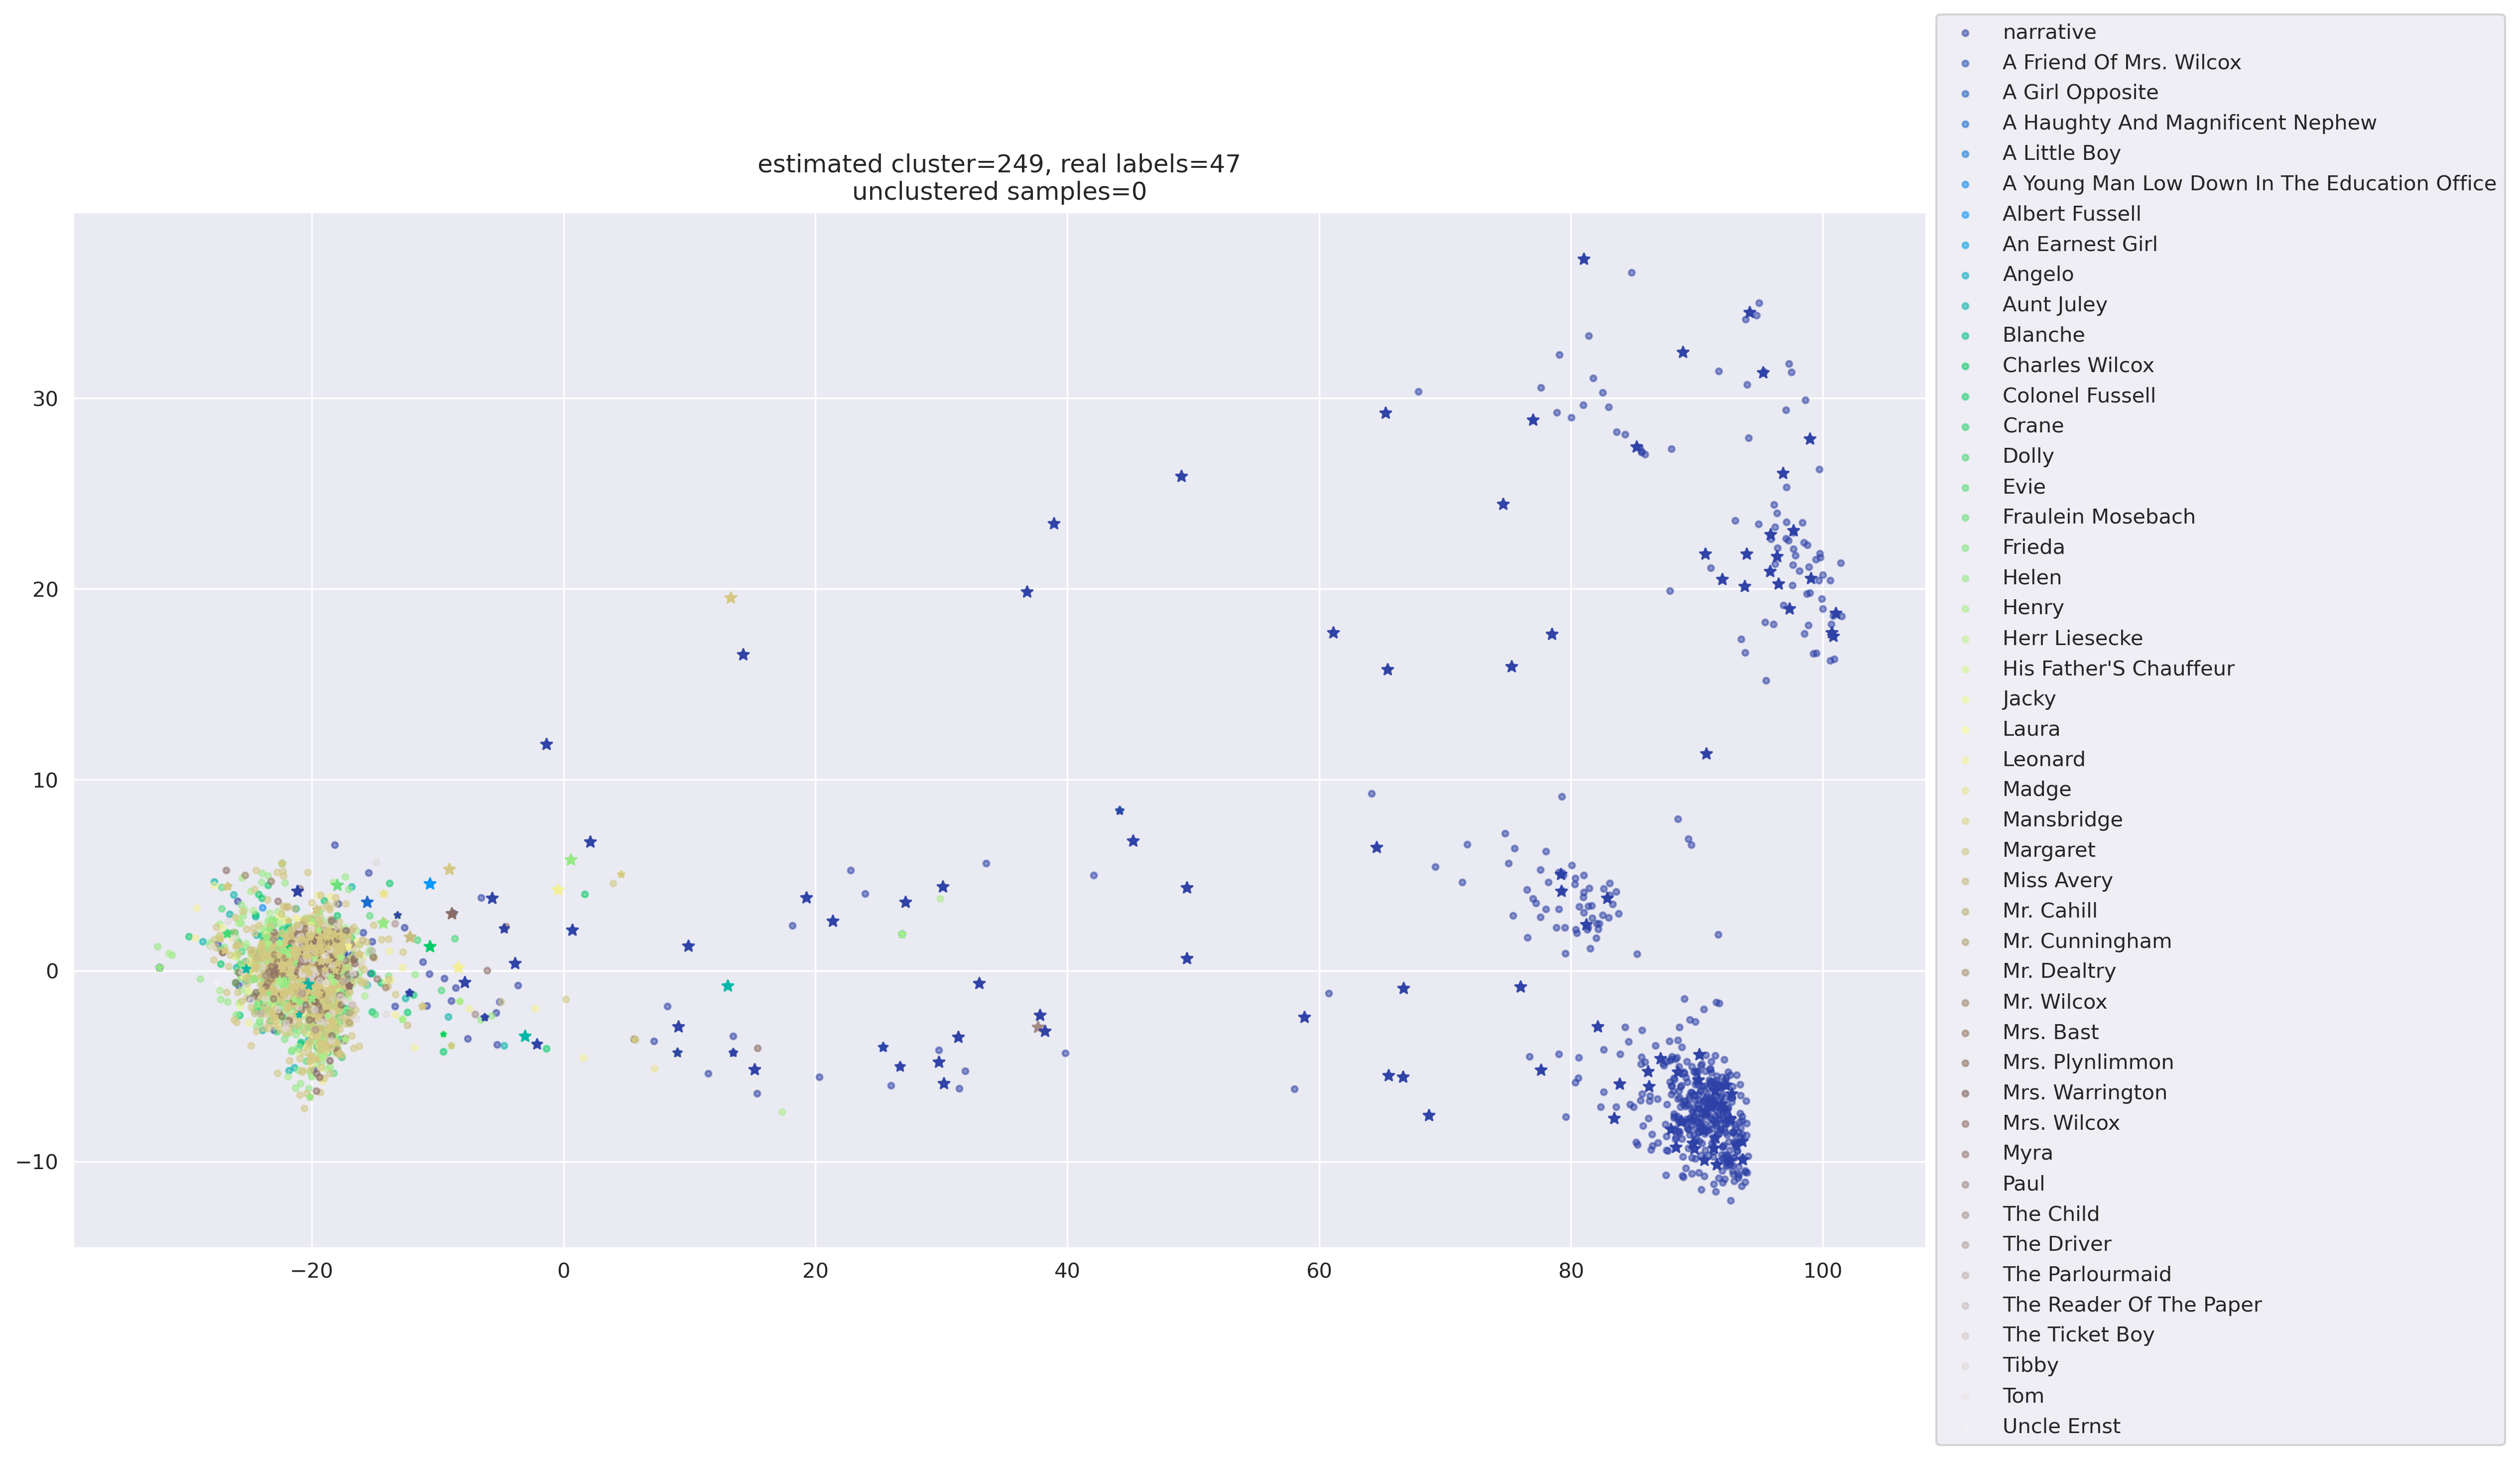

In [35]:
import visualize

fig = visualize.plot_affinity_cluster(ap, cls_features, speakers)

fig.show()

In [43]:
labels_to_idx = dict()

speaker_list = list(set(speakers))

for i, l in enumerate(speaker_list):
    labels_to_idx[l] = i

label_indices = [labels_to_idx[l] for l in speakers]

In [46]:
score = metrics.homogeneity_completeness_v_measure(labels_true=label_indices, labels_pred=ap.labels_)

print(score)

(0.9999999999999998, 0.2821792146506184, 0.44015565285467456)
